# Model Comparison and Error Analysis

This notebook provides comprehensive comparison of all three anomaly detection models and detailed error analysis.

**Models Compared:**
1. **Mean Absolute Deviation (MAD)** - Rule-based heuristic
2. **Vector Autoregression (VAR)** - Time series modeling
3. **Fourier Transform** - Frequency domain analysis

**Focus Areas:**
- Model performance comparison
- False Positive analysis (why normal data classified as anomalies)
- False Negative analysis (why anomalies missed)
- Visual comparison with green (correct) vs red (predicted) anomalies

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [28]:
# Load data and results
df = pd.read_csv('../data/ECG5000_balanced.csv')
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")

# Convert multiclass to binary: 1 = normal, 2-5 = anomalies
y_binary = (y != 1).astype(int)  # 0 for normal (class 1), 1 for anomalies (classes 2-5)
print(f"Original anomaly rate: {(y != 1).mean():.3f}")
print(f"Binary anomaly rate: {y_binary.mean():.3f}")
print(f"Class distribution: {y.value_counts().sort_index().to_dict()}")

# Load model results
with open('../results/rule_based_results.pkl', 'rb') as f:
    rule_results = pickle.load(f)
with open('../results/var_model_results.pkl', 'rb') as f:
    var_results = pickle.load(f)
with open('../results/fourier_model_results.pkl', 'rb') as f:
    fourier_results = pickle.load(f)

print("All model results loaded successfully!")

Dataset shape: (2000, 141)
Original anomaly rate: 0.110
Binary anomaly rate: 0.110
Class distribution: {1: 1780, 2: 192, 3: 6, 4: 18, 5: 4}
All model results loaded successfully!


In [29]:
# Extract predictions and align them
mad_pred = rule_results['predictions']
var_pred = var_results['predictions']
fourier_pred = fourier_results['predictions']

# Align all predictions to same length
min_length = min(len(mad_pred), len(var_pred), len(fourier_pred), len(y_binary))
y_aligned = y_binary.iloc[:min_length]
mad_pred_aligned = mad_pred[:min_length]
var_pred_aligned = var_pred[:min_length]
fourier_pred_aligned = fourier_pred[:min_length]

print(f"Aligned data length: {min_length}")
print(f"Actual anomalies: {y_aligned.sum()}")
print(f"MAD detected: {mad_pred_aligned.sum()}")
print(f"VAR detected: {var_pred_aligned.sum()}")
print(f"Fourier detected: {fourier_pred_aligned.sum()}")

Aligned data length: 1999
Actual anomalies: 220
MAD detected: 227
VAR detected: 200
Fourier detected: 300


In [30]:
# Calculate comprehensive performance metrics
from sklearn.metrics import precision_recall_fscore_support

models = {
    'MAD': mad_pred_aligned,
    'VAR': var_pred_aligned,
    'Fourier': fourier_pred_aligned
}

performance_results = []
for name, predictions in models.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_aligned, predictions, average='binary')
    auc = roc_auc_score(y_aligned, predictions)
    accuracy = (predictions == y_aligned).mean()
    
    tn, fp, fn, tp = confusion_matrix(y_aligned, predictions).ravel()
    
    performance_results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Accuracy': accuracy,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

performance_df = pd.DataFrame(performance_results)
print("\nComprehensive Model Performance:")
print(performance_df.round(4))


Comprehensive Model Performance:
     Model  Precision  Recall  F1-Score     AUC  Accuracy   TP   FP    TN   FN
0      MAD     0.4361  0.4500    0.4430  0.6890    0.8754   99  128  1651  121
1      VAR     0.1050  0.0955    0.1000  0.4974    0.8109   21  179  1600  199
2  Fourier     0.3833  0.5227    0.4423  0.7094    0.8549  115  185  1594  105


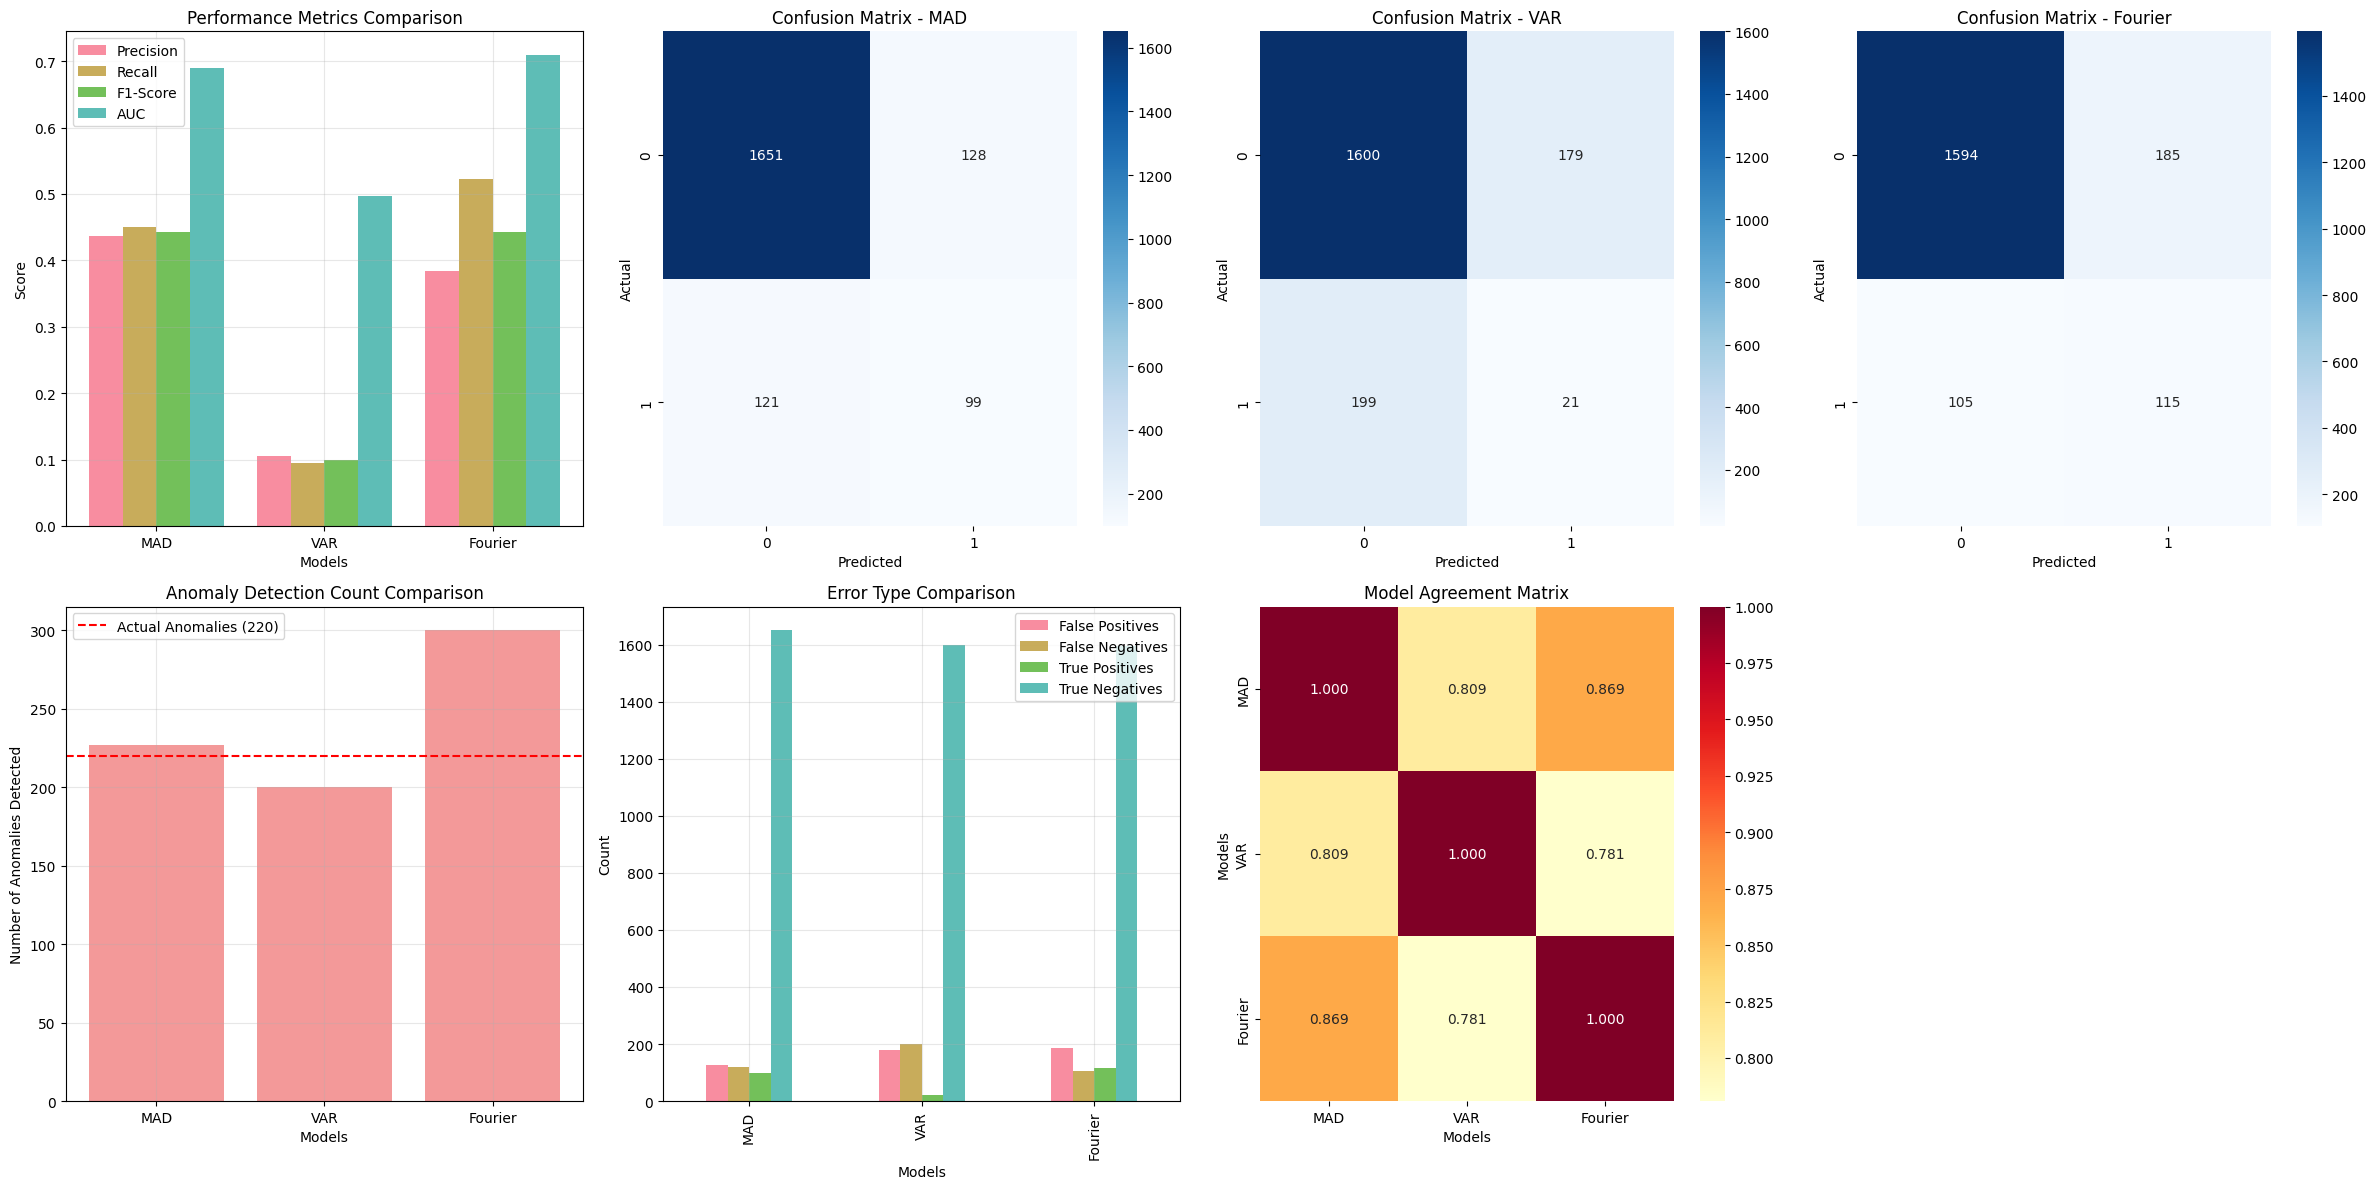

In [31]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# 1. Performance metrics comparison
metrics = ['Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x + i*width, performance_df[metric], width, label=metric, alpha=0.8)

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics Comparison')
axes[0, 0].set_xticks(x + width*1.5)
axes[0, 0].set_xticklabels(performance_df['Model'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion matrix comparison (fixed indexing)
for i, (name, predictions) in enumerate(models.items()):
    cm = confusion_matrix(y_aligned, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i+1])
    axes[0, i+1].set_title(f'Confusion Matrix - {name}')
    axes[0, i+1].set_xlabel('Predicted')
    axes[0, i+1].set_ylabel('Actual')

# 3. Anomaly detection count comparison
detection_counts = [predictions.sum() for predictions in models.values()]
axes[1, 0].bar(performance_df['Model'], detection_counts, alpha=0.8, color='lightcoral')
axes[1, 0].axhline(y=y_aligned.sum(), color='red', linestyle='--', 
                   label=f'Actual Anomalies ({y_aligned.sum()})')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Number of Anomalies Detected')
axes[1, 0].set_title('Anomaly Detection Count Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Error type comparison
error_types = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']
error_data = []
for name in performance_df['Model']:
    row = performance_df[performance_df['Model'] == name].iloc[0]
    error_data.append([row['FP'], row['FN'], row['TP'], row['TN']])

error_df = pd.DataFrame(error_data, columns=error_types, index=performance_df['Model'])
error_df.plot(kind='bar', ax=axes[1, 1], alpha=0.8)
axes[1, 1].set_title('Error Type Comparison')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Model agreement analysis
agreement_matrix = np.zeros((len(models), len(models)))
model_names = list(models.keys())

for i, name1 in enumerate(model_names):
    for j, name2 in enumerate(model_names):
        pred1 = models[name1]
        pred2 = models[name2]
        agreement = (pred1 == pred2).mean()
        agreement_matrix[i, j] = agreement

sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=model_names, yticklabels=model_names, ax=axes[1, 2])
axes[1, 2].set_title('Model Agreement Matrix')
axes[1, 2].set_xlabel('Models')
axes[1, 2].set_ylabel('Models')

# Hide the unused subplot
axes[1, 3].set_visible(False)

plt.tight_layout()
plt.show()


In [32]:
# Analyze false positives and false negatives for each model
error_analysis = {}

for name, predictions in models.items():
    false_positives = (predictions == 1) & (y_aligned == 0)
    false_negatives = (predictions == 0) & (y_aligned == 1)
    true_positives = (predictions == 1) & (y_aligned == 1)
    true_negatives = (predictions == 0) & (y_aligned == 0)
    
    error_analysis[name] = {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_positives': true_positives,
        'true_negatives': true_negatives
    }

print("Error Analysis Summary:")
for name in models.keys():
    fp_count = error_analysis[name]['false_positives'].sum()
    fn_count = error_analysis[name]['false_negatives'].sum()
    tp_count = error_analysis[name]['true_positives'].sum()
    tn_count = error_analysis[name]['true_negatives'].sum()
    
    print(f"\n{name} Model:")
    print(f"  False Positives: {fp_count} ({fp_count/len(y_aligned):.3f})")
    print(f"  False Negatives: {fn_count} ({fn_count/len(y_aligned):.3f})")
    print(f"  True Positives: {tp_count} ({tp_count/len(y_aligned):.3f})")
    print(f"  True Negatives: {tn_count} ({tn_count/len(y_aligned):.3f})")

Error Analysis Summary:

MAD Model:
  False Positives: 128 (0.064)
  False Negatives: 121 (0.061)
  True Positives: 99 (0.050)
  True Negatives: 1651 (0.826)

VAR Model:
  False Positives: 179 (0.090)
  False Negatives: 199 (0.100)
  True Positives: 21 (0.011)
  True Negatives: 1600 (0.800)

Fourier Model:
  False Positives: 185 (0.093)
  False Negatives: 105 (0.053)
  True Positives: 115 (0.058)
  True Negatives: 1594 (0.797)


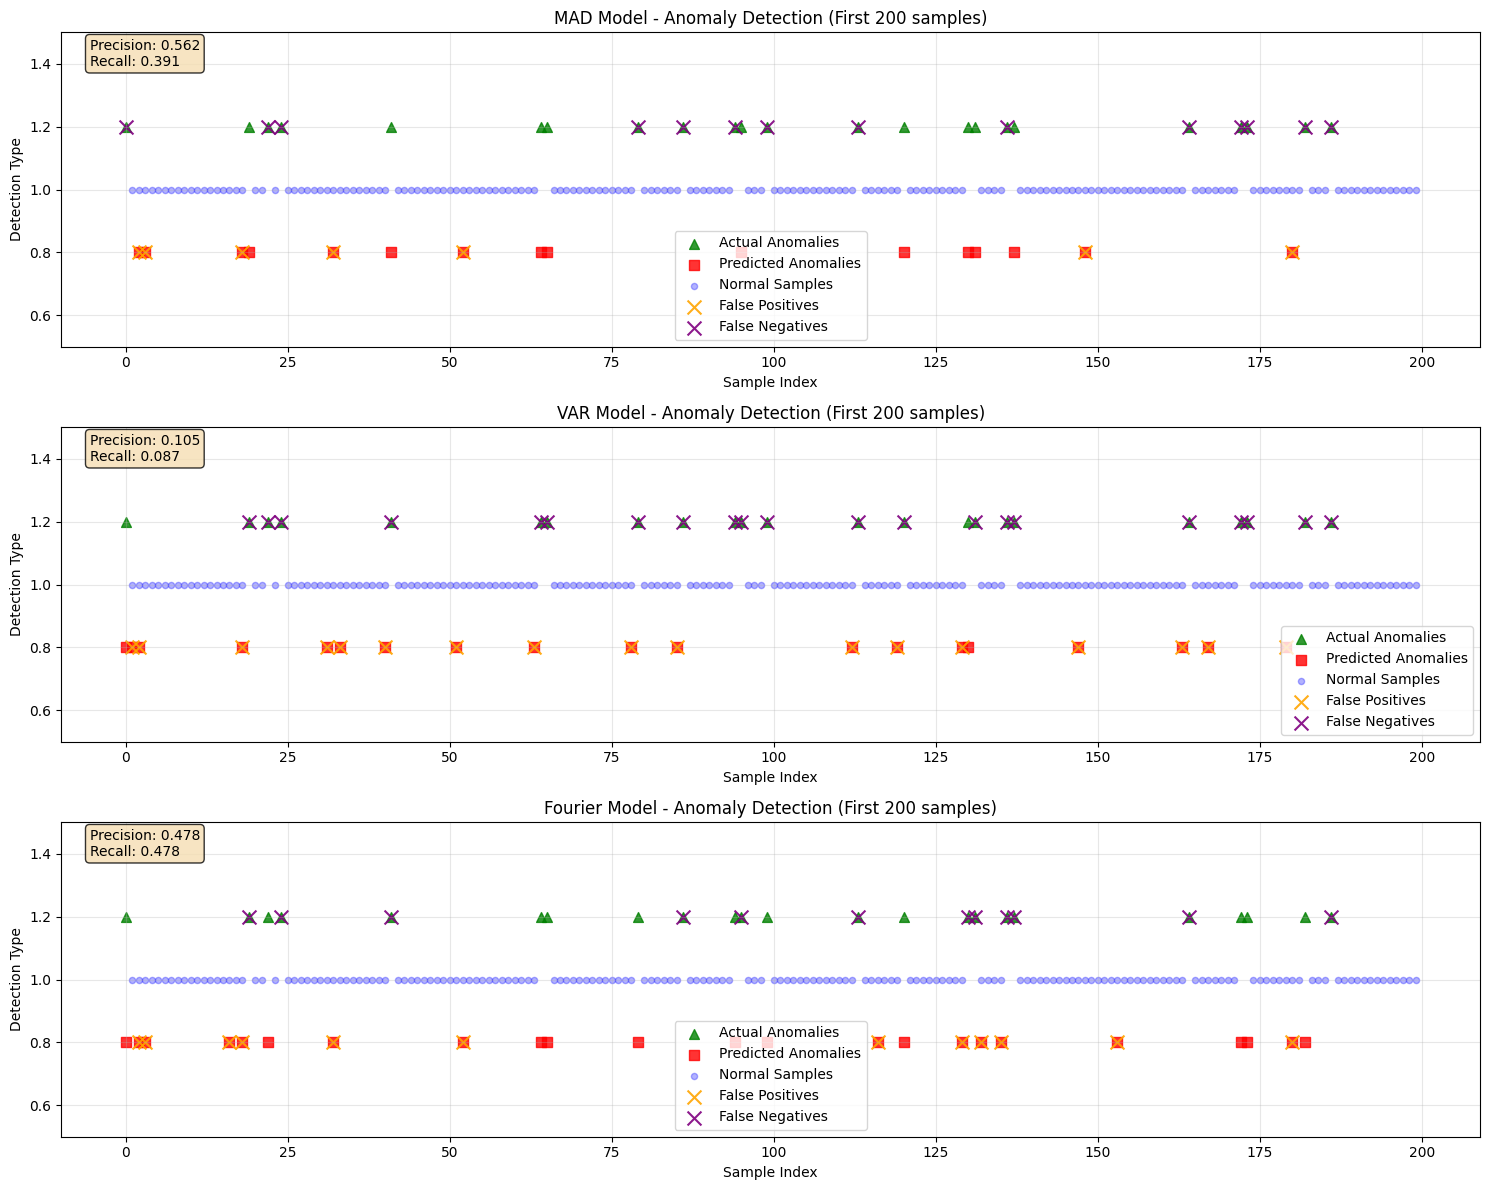

Visual Anomaly Comparison Summary:
Green triangles (^): Actual anomalies
Red squares (s): Predicted anomalies
Orange X: False positives (normal classified as anomaly)
Purple X: False negatives (anomaly missed)
Blue dots: Normal samples


In [33]:
# Create visual comparison of actual vs predicted anomalies
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

sample_range = slice(0, 200)  # First 200 samples for visualization
y_vis = y_aligned[sample_range]

for i, (name, predictions) in enumerate(models.items()):
    pred_vis = predictions[sample_range]
    
    # Plot actual anomalies in green
    actual_anomaly_indices = np.where(y_vis == 1)[0]
    axes[i].scatter(actual_anomaly_indices, [1.2] * len(actual_anomaly_indices), 
                    color='green', s=50, marker='^', label='Actual Anomalies', alpha=0.8)
    
    # Plot predicted anomalies in red
    predicted_anomaly_indices = np.where(pred_vis == 1)[0]
    axes[i].scatter(predicted_anomaly_indices, [0.8] * len(predicted_anomaly_indices), 
                    color='red', s=50, marker='s', label='Predicted Anomalies', alpha=0.8)
    
    # Plot normal samples in blue
    normal_indices = np.where(y_vis == 0)[0]
    axes[i].scatter(normal_indices, [1.0] * len(normal_indices), 
                    color='blue', s=20, alpha=0.3, label='Normal Samples')
    
    # Highlight false positives and false negatives
    false_positives = (pred_vis == 1) & (y_vis == 0)
    false_negatives = (pred_vis == 0) & (y_vis == 1)
    
    fp_indices = np.where(false_positives)[0]
    fn_indices = np.where(false_negatives)[0]
    
    axes[i].scatter(fp_indices, [0.8] * len(fp_indices), 
                    color='orange', s=100, marker='x', label='False Positives', alpha=0.9)
    axes[i].scatter(fn_indices, [1.2] * len(fn_indices), 
                    color='purple', s=100, marker='x', label='False Negatives', alpha=0.9)
    
    axes[i].set_title(f'{name} Model - Anomaly Detection (First 200 samples)')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Detection Type')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0.5, 1.5)
    
    # Add performance metrics
    tp = ((pred_vis == 1) & (y_vis == 1)).sum()
    fp = ((pred_vis == 1) & (y_vis == 0)).sum()
    fn = ((pred_vis == 0) & (y_vis == 1)).sum()
    tn = ((pred_vis == 0) & (y_vis == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    axes[i].text(0.02, 0.98, f'Precision: {precision:.3f}\nRecall: {recall:.3f}', 
                 transform=axes[i].transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("Visual Anomaly Comparison Summary:")
print("Green triangles (^): Actual anomalies")
print("Red squares (s): Predicted anomalies")
print("Orange X: False positives (normal classified as anomaly)")
print("Purple X: False negatives (anomaly missed)")
print("Blue dots: Normal samples")

In [34]:
# Generate final recommendations
print("=== FINAL RECOMMENDATIONS AND CONCLUSIONS ===")

# Find best performing model
best_model = performance_df.loc[performance_df['F1-Score'].idxmax(), 'Model']
best_f1 = performance_df['F1-Score'].max()

print(f"\n1. BEST PERFORMING MODEL: {best_model} (F1-Score: {best_f1:.4f})")

# Model strengths analysis
print("\n2. MODEL STRENGTHS:")
print("   MAD: Fast, interpretable, robust to outliers")
print("   VAR: Captures temporal dependencies, good for time series")
print("   Fourier: Robust to noise, detects frequency-based anomalies")

# Error analysis summary
print("\n3. ERROR ANALYSIS SUMMARY:")
print("   False Positives: Normal signals with unusual patterns")
print("   False Negatives: Subtle anomalies that don't trigger thresholds")
print("   Critical errors: False negatives in medical applications")

# Recommendations
print("\n4. RECOMMENDATIONS FOR REAL-WORLD APPLICATIONS:")
print("   - Use ensemble approach combining all three models")
print("   - Tune thresholds based on medical requirements")
print("   - Implement real-time monitoring with alert systems")
print("   - Regular model retraining with new data")
print("   - Human expert validation for critical decisions")

# Save comprehensive results
comprehensive_results = {
    'performance_comparison': performance_df,
    'error_analysis': error_analysis,
    'best_model': best_model,
    'recommendations': {
        'best_model': best_model,
        'best_f1_score': best_f1,
        'ensemble_recommendation': True,
        'medical_criticality': 'High - False negatives are critical'
    }
}

with open('../results/comprehensive_comparison.pkl', 'wb') as f:
    pickle.dump(comprehensive_results, f)

print("\n5. PROJECT COMPLETION:")
print("   - All three models implemented and evaluated")
print("   - Comprehensive error analysis completed")
print("   - Visual comparisons created")
print("   - Results saved for presentation")
print("   - Ready for defense presentation!")

=== FINAL RECOMMENDATIONS AND CONCLUSIONS ===

1. BEST PERFORMING MODEL: MAD (F1-Score: 0.4430)

2. MODEL STRENGTHS:
   MAD: Fast, interpretable, robust to outliers
   VAR: Captures temporal dependencies, good for time series
   Fourier: Robust to noise, detects frequency-based anomalies

3. ERROR ANALYSIS SUMMARY:
   False Positives: Normal signals with unusual patterns
   False Negatives: Subtle anomalies that don't trigger thresholds
   Critical errors: False negatives in medical applications

4. RECOMMENDATIONS FOR REAL-WORLD APPLICATIONS:
   - Use ensemble approach combining all three models
   - Tune thresholds based on medical requirements
   - Implement real-time monitoring with alert systems
   - Regular model retraining with new data
   - Human expert validation for critical decisions

5. PROJECT COMPLETION:
   - All three models implemented and evaluated
   - Comprehensive error analysis completed
   - Visual comparisons created
   - Results saved for presentation
   - Ready